In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import palettable
import cmcrameri
from copy import copy
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import CRS, Transformer

In [3]:
PROJ4STR = "+proj=somerc +lat_0=46.95240555555556 +lon_0=7.439583333333333 +k_0=1 +x_0=2600000 +y_0=1200000 +ellps=bessel +towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs"

LL_lon = 3.169
LL_lat = 43.6301
UL_lon = 2.6896
UL_lat = 49.3767
LR_lon = 11.9566
LR_lat = 43.6201
UR_lon = 12.4634
UR_lat = 49.3654
XSIZE = 710
YSIZE = 640

# Get projection
crs = CRS.from_proj4(PROJ4STR)
crs_4326 = CRS.from_epsg(4326)
transformer = Transformer.from_crs(crs_4326, crs, always_xy=True)
x1, y1 = transformer.transform(
    LL_lon,
    LL_lat,
)
x2, y2 = transformer.transform(
    UR_lon,
    UR_lat,
)

XCOORDS = np.linspace(
    x1,
    x2,
    XSIZE,
)
YCOORDS = np.linspace(
    y1,
    y2,
    YSIZE,
)

RADAR_COL = "tab:orange"
RADAR_SIZE = 10
RADAR_MARKER = "X"

In [4]:
dem_path = "/data/jenna/3d-ml-nowcasting/COSMO1topo_ccs4/COSMO1_topography_parameters.nc"

dem = xr.open_dataset(dem_path)
dem = dem.assign_coords(p_j=dem.x.values, p_i=dem.y.values)

dem.data_vars

Data variables:
    x         (p_j) float32 3kB 2.555e+05 2.565e+05 ... 9.642e+05 9.652e+05
    y         (p_i) float32 3kB -1.595e+05 -1.585e+05 ... 4.785e+05 4.795e+05
    EW_deriv  (p_i, p_j) float32 2MB ...
    NS_deriv  (p_i, p_j) float32 2MB ...
    WE_deriv  (p_i, p_j) float32 2MB ...
    SN_deriv  (p_i, p_j) float32 2MB ...
    TPI_1     (p_i, p_j) float32 2MB ...
    TPI_2     (p_i, p_j) float32 2MB ...
    TPI_3     (p_i, p_j) float32 2MB ...
    morpho_1  (p_i, p_j) float32 2MB ...
    morpho_2  (p_i, p_j) float32 2MB ...
    morpho_3  (p_i, p_j) float32 2MB ...
    ifac_1    (p_i, p_j) float32 2MB ...
    ifac_2    (p_i, p_j) float32 2MB ...
    ifac_3    (p_i, p_j) float32 2MB ...
    Altitude  (p_i, p_j) float32 2MB ...
    Aspect    (p_i, p_j) float32 2MB ...
    Slope     (p_i, p_j) float32 2MB ...

In [8]:
import geopandas as gpd
from matplotlib.collections import LineCollection

data_proj4 = "+proj=somerc +lat_0=46.95240555555556 +lon_0=7.439583333333333 +k_0=1 +x_0=2600000 +y_0=1200000 +ellps=bessel +towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs"
epsg = 21781  

# Borders
border = gpd.read_file("Border_CH.shp")
border_proj = border.to_crs(data_proj4)

segments = [
    np.array(linestring.coords)[:, :2] for linestring in border_proj["geometry"]
]
border_collection = LineCollection(segments, color="k", linewidth=2, zorder=10)

# Radar locations
radar_locations = gpd.read_file("swiss_radars.shp")
radar_locations_proj = radar_locations.to_crs(data_proj4)
xy = radar_locations_proj["geometry"].map(lambda point: point.xy)
radar_locations_proj = list(zip(*xy))

In [9]:
from pyproj import Transformer

# Transform from LV95 to proj4
transformer = Transformer.from_crs(f"EPSG:{epsg}", data_proj4, always_xy=True)

xx, yy = np.meshgrid(dem.x.values, dem.y.values)

xx_dataproj, yy_dataproj = transformer.transform(xx, yy)

x_dataproj = xx_dataproj[0, :] 
y_dataproj = yy_dataproj[:, 0] 

dem = dem.assign_coords(p_j=x_dataproj, p_i=y_dataproj)

In [10]:
# Colormap for altitude
# colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 1))
# colors_land = plt.cm.terrain(np.linspace(0.25, 1, 16))

colors_undersea = cmcrameri.cm.bukavu(np.linspace(0.2, 0.3, 1))
colors_land = cmcrameri.cm.bukavu_r(np.linspace(0.0, 0.499, 16))

all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = mpl.colors.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)

# make the norm:  Note the center is offset so that the land has more
# dynamic range:
bounds = [*np.arange(-250, 0, 250), *np.arange(0, 4000.1, 250)]
terrain_norm = mpl.colors.BoundaryNorm(bounds, terrain_map.N)

In [13]:
# BBOX_LCNN = [269, 525, 203, 459]
BBOX_LCNN = [203, 459, 269, 525]

y_dataproj.shape

BBOX_LCNN_CORNER_COORDINATES = np.array([
    [x_dataproj[BBOX_LCNN[0]], y_dataproj[BBOX_LCNN[2]]], # lower left
    [x_dataproj[BBOX_LCNN[1]], y_dataproj[BBOX_LCNN[2]]], # lower right
    [x_dataproj[BBOX_LCNN[1]], y_dataproj[BBOX_LCNN[3]]], # upper right
    [x_dataproj[BBOX_LCNN[0]], y_dataproj[BBOX_LCNN[3]]], # upper left
    [x_dataproj[BBOX_LCNN[0]], y_dataproj[BBOX_LCNN[2]]], # lower left
])

BBOX_LCNN_CORNER_COORDINATES.shape

(5, 2)

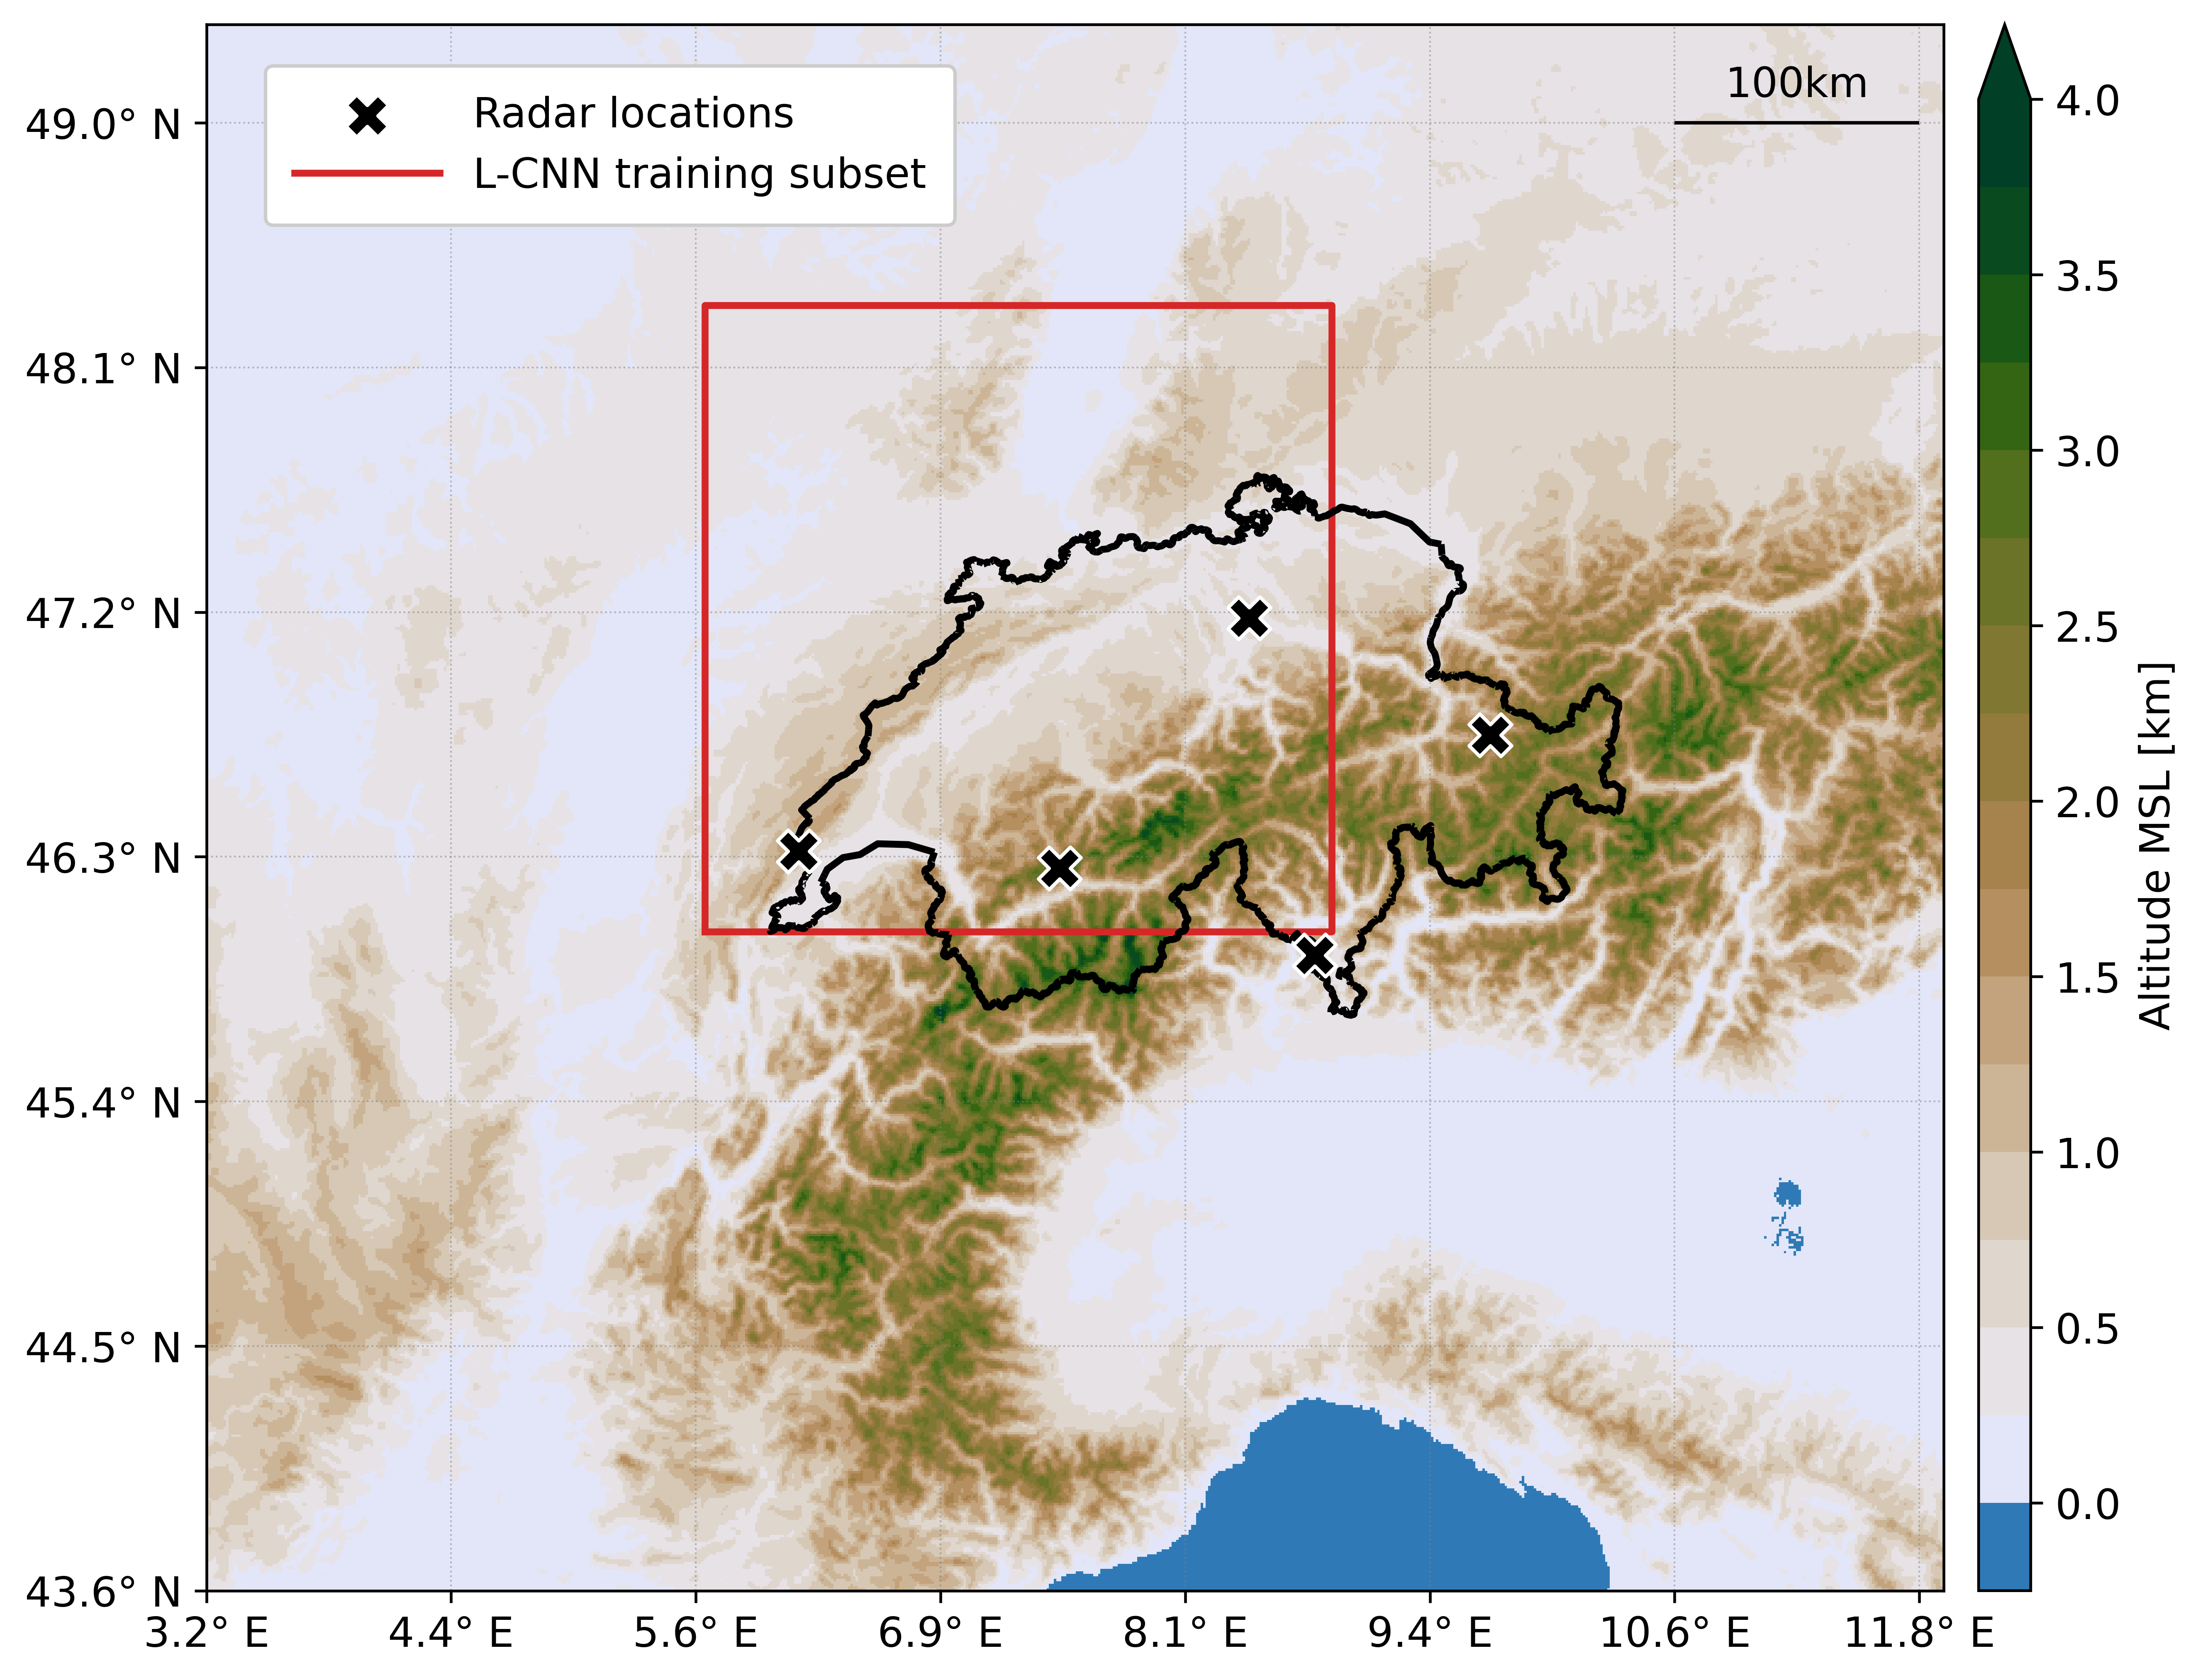

In [47]:
style = "domain_figure_article"
plt.style.use('default')
plt.style.use(f"/home/users/ritvanen/koodaus/cell-tracking-article-code/config/stylefiles/{style}.mplstyle")

fig, axs = plt.subplots(1, 1, figsize=(8,8))

cbar_ax_kws = {
    "width": "3%",  # width = 5% of parent_bbox width
    "height": "100%",
    "loc": "lower left",
    "bbox_to_anchor": (1.02, 0.0, 1, 1),
    "borderpad": 0,
}

plot_field = "Altitude"

cax = inset_axes(axs, bbox_transform=axs.transAxes, **cbar_ax_kws)

dem[plot_field].plot(ax=axs, rasterized=True, norm=terrain_norm, cmap=terrain_map, cbar_ax=cax)

cax.set_yscale('linear')
cax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f"{x / 1e3:.1f}"))
cax.set_ylabel("Altitude MSL [km]", labelpad=5)

# Plot Swiss borders and radars on top
axs.add_collection(copy(border_collection))

if radar_locations_proj is not None:
    axs.scatter(
        *radar_locations_proj,
        color="black",
        edgecolor="white",
        s=150,
        marker="X",
        zorder=10,
        label="Radar locations",
    )
    
# Plot bbox
axs.plot(
    BBOX_LCNN_CORNER_COORDINATES[:, 0],
    BBOX_LCNN_CORNER_COORDINATES[:, 1],
    color="tab:red",
    label="L-CNN training subset",
    lw="2",
)

xticks = np.arange(
    XCOORDS.min(), XCOORDS.max(), 100 * 1e3
)
axs.set_xticks(xticks)
axs.set_yticks(
    np.arange(
        YCOORDS.min(), YCOORDS.max(), 100 * 1e3
    )
)
axs.set_aspect(1)

axs.set_xlim((XCOORDS.min(), XCOORDS.max()))
axs.set_ylim((YCOORDS.min(), YCOORDS.max()))

axs.set_aspect("equal")
axs.grid(which="both", axis="both", lw=0.5, color="tab:gray", ls=":", zorder=11)
axs.label_outer()

# axs.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10e4))
# axs.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10e4))

transformer = Transformer.from_crs(data_proj4, "EPSG:4326", always_xy=True)

# lon_ticks, lat_ticks = transformer.transform(axs.get_xticks(), axs.get_yticks()[0)

xticks = axs.get_xticks()
yticks = axs.get_yticks()

lonxticks, latxticks = transformer.transform(xticks, [yticks[0]]*len(xticks))
lonyticks, latyticks = transformer.transform([xticks[0]]*len(yticks), yticks)

axs.set_xticklabels([f"{l:.1f}° E" for l in lonxticks])
axs.set_yticklabels([f"{l:.1f}° N" for l in latyticks])

# Add legend for radar locations
axs.legend(
    loc="upper left",
    bbox_to_anchor=(0.01, 1),
    borderaxespad=1,
    frameon=True,
    fancybox=True, 
    framealpha=1, 
    shadow=False, 
    borderpad=0.7
)

# axs.set_xlabel("Longitude")
# axs.set_ylabel("Latitude")
axs.set_xlabel("")
axs.set_ylabel("")

# axs.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f"{x:.1f}"))
# axs.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f"{x:.1f}"))

# Add scalebar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
fontprops = mpl.font_manager.FontProperties(size="large")
scalebar = AnchoredSizeBar(
    axs.transData,                       
    100e3, 
    '100km', 
    'lower left', 
    # loc=(0.9, 0.9),
    # bbox_to_anchor=(600e3, 610e3),
    bbox_to_anchor=(xticks[-2], YCOORDS.min() + 600e3),
    bbox_transform=axs.transData,
    pad=0.,
    borderpad=0.,
    color='k',
    sep=5,
    frameon=False,
    size_vertical=2,
    label_top=True,
    fontproperties=fontprops
)

axs.add_artist(scalebar)


for ext in ["png", "pdf", "svg"]:
    outpath = Path(".").parent / f"domain_figure_{plot_field}_{style}.{ext}"
    fig.savefig(outpath)


In [17]:
XCOORDS.max()

2965062.5247233

In [19]:
BBOX_LCNN_CORNER_COORDINATES.max() - XCOORDS.max()


-184037.52472329978